# Calculate and save footprints over entire period.

* ## Intersect with a map of the basin 

* ### Query given footprints and calculate contours

In [24]:
%matplotlib notebook
import sys
import os
import time
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, shape
import rasterio
from rasterio import features
from rasterio.transform import from_origin
from matplotlib import pyplot as plt
from geopandas import GeoDataFrame
from datetime import datetime
import datetime
from rasterio.plot import show
import Footprint_Processing as FP
import importlib

DateRange=['2016-6-23 12:00:00','2016-8-23 23:30:00']  ## Subset for testing
# DateRange=['2016-7-12 12:00:00','2016-7-14 23:30:00']  ## Subset for testing
Axis = 40
rs = [50,75,90]
dx = 1
XY = [516095.94,7707929.74] ## From the Map
# XY = [516098.07,7707934.37] ## From Eddypro GPS
nx = 1000
fp_params={'dx':dx,'nx':nx,'rs':rs}
west = XY[0]-(nx*dx)/2
north = XY[1]+(nx*dx)/2

thres=.05

RasterPath = 'C:/Illisarvik/Footprints/'
DataName = 'C:/Illisarvik/FilteredData2019-02-15.csv'


In [25]:

Filter = 30
Data = pd.read_csv(DataName)
Data = Data.set_index(pd.DatetimeIndex(Data.datetime))
Data['Run']=np.nan
Data.loc[(np.isfinite(Data['wind_dir'])==True)&(Data['u*']>.1)&
#          (Data.index>DateRange[0])&(Data.index<DateRange[1])&              # Run a subset for teting
         ((Data['wind_dir']<Axis+180-Filter)|(Data['wind_dir']>Axis+180+Filter))&
         ((Data['wind_dir']<Axis+180-Filter)|(Data['wind_dir']>Axis)),
         'Run']=1
Data.loc[(Data.index<DateRange[0])|(Data.index>DateRange[1]),'Run']=0

Data['Zo']=Data['canopy_height'] * .10
Data['d']=Data['canopy_height'].mean()*.66
Data['Z_L'] = Data['Zm']/Data['L']


# f = plt.figure(figsize = (10,8))
# f = plt.figure(figsize = (7,7))
# # ax = f.add_axes([0.05, 0.6, .9, 0.35]) # Left, Bottom, Width, Height
# # ax2 = f.add_axes([0.0, 0, 1, .55], polar=True)
# ax2 = f.add_axes([0.0, 0, 1, 1], polar=True)


# ax.plot(Data['Zo'],label = 'Measurement Based')


Data['Zm']=Data['Zm']-Data['d']
Data['Z_L'] = Data['Zm']/Data['L']
Data['Z0'] = Data['Zm']*np.exp(-.41*Data['wind_speed']/Data['u*'])

Data.loc[(Data['Z_L']<-thres)|(Data['Z_L']>thres),['Z0']]=np.nan




TempData = Data[np.isfinite(Data['Run'])]
Total_Obs = TempData['Run'].count()
Var = 'fch4'

Wind_Groups_median = TempData.groupby(['Dir']).median()
Wind_Groups_std = TempData.groupby(['Dir']).std()
Wind_Groups_Ct = TempData.groupby(['Dir']).count()
Wind_Groups_CI = Wind_Groups_std/Wind_Groups_Ct**.5*1.96

Wind_Groups_median['Dir'] = Wind_Groups_median.index*np.pi/180

Wind_Groups_median['Pos'] = Wind_Groups_median[Var]*1
Wind_Groups_median['Neg'] = Wind_Groups_median[Var]*1

Wind_Groups_median.loc[Wind_Groups_median[Var]<0,'Pos']*=0
Wind_Groups_median.loc[Wind_Groups_median[Var]>0,'Neg']*=0
Wind_Groups_median.loc[Wind_Groups_median[Var]<0,'Neg']*=-1

# Counts
# ax2.bar(Wind_Groups_median['Dir'],Wind_Groups_Ct[Var].values/Total_Obs,edgecolor='black',width = 30*np.pi/180)
print(Wind_Groups_Ct[Var].sum()/Total_Obs)


# ax2.set_theta_direction(-1)
# ax2.set_theta_offset(0)
# ax2.set_theta_zero_location('N')
# ax2.set_thetagrids([0,45,90,135,180,225,270,315],['N','NE','E','SE','S','SW','W','NW'])

for d in Wind_Groups_median.index:
    Data.loc[Data['Dir']==d,'Zo']=Wind_Groups_median.loc[d]['Z0']
Data['Zo'] = Data['Zo'].fillna(100)
# print(Data[10:60]['AirTC_Avg'])
# ax.plot(Data['Zo'])

# fig = plt.figure()
# # print(Data['VWC'])
# Data.loc[Data['VWC']<.4,'VWC']=np.nan
# Data['VWC'] = Data['VWC'].interpolate('linear')
# plt.plot(Data['VWC'],label='nu')
# plt.legend()

# print(Data['PBLH'])

0.7913043478260869


# Date Range & Paramters
## Read & filter the data, initialize the Basin Map

| 1.00, 0.00, 515595.94|
| 0.00,-1.00, 7708429.74|
| 0.00, 0.00, 1.00|


<IPython.core.display.Javascript object>


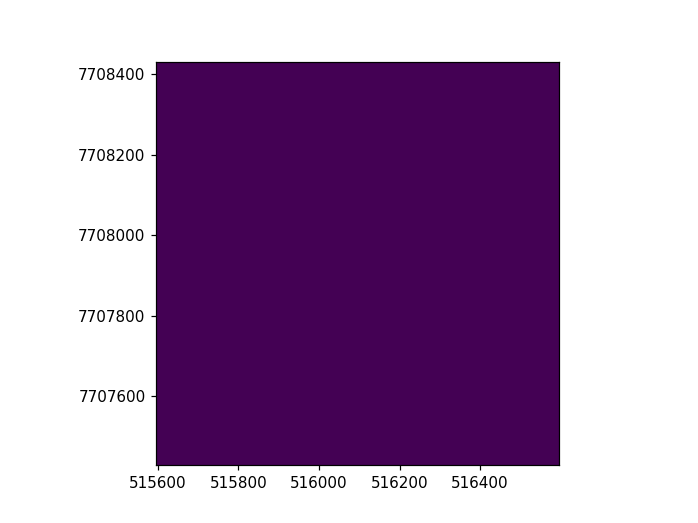

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 1001, 'height': 1001, 'count': 1, 'crs': CRS.from_dict(init='epsg:32608'), 'transform': Affine(1.0, 0.0, 515595.94,
       0.0, -1.0, 7708429.74), 'tiled': False, 'interleave': 'band'}


In [26]:

Basin = gpd.read_file('C:\\Illisarvik\\Mapping/Vegetation_Skeeter_3.3.shp')
Basin['Area'] = Basin.area
# Basin['Unit'] = Basin['Code'].astype(float)
Code = 'Unit'
Name = 'Class'
Basin[Code] = Basin[Code].astype(float)


shapes = ((geom,value) for geom,value in zip(Basin['geometry'],Basin[Code]))
west = XY[0]-(nx*dx)/2
north = XY[1]+(nx*dx)/2
Transform = from_origin(west,north,dx,dx)
print(Transform)

plt.figure()
with rasterio.open('Basin_Image.tif','r',driver='GTiff',width = nx+1, height = nx+1,count = 1,
                   dtype=np.float64,transform = Transform,crs = ({'init': 'EPSG:32608'})) as out:
    
    out_arr = out.read(1)
with rasterio.open('Basin_Image.tif','w',driver='GTiff',width = nx+1, height = nx+1,count = 1,
                   dtype=np.float64,transform = Transform,crs = ({'init': 'EPSG:32608'})) as out:
    
#     out_arr = out.read(1)
    params = out.profile
    print(params)
#     del params['transform']
    Basin_Image = features.rasterize(shapes=shapes,fill = 100,
                                     out = out_arr,transform = Transform,default_value=0,dtype=np.float64)
    out.write(Basin_Image,1)
#     print(out.read(1))
with rasterio.open('Basin_Image.tif','r',driver='GTiff',width = nx+1, height = nx+1,count = 1,
                   dtype=np.float64,affine = Transform,crs = ({'init': 'EPSG:32608'})) as out:
    show((out))
# print(Basin_Image.max())


## Footprints

[||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||] 100.0%
949742.8730362045 0.9683926326271584
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 1001, 'height': 1001, 'count': 1, 'crs': CRS.from_dict(init='epsg:32608'), 'transform': Affine(1.0, 0.0, 515595.94,
       0.0, -1.0, 7708429.74), 'tiled': False, 'interleave': 'band'}


<IPython.core.display.Javascript object>


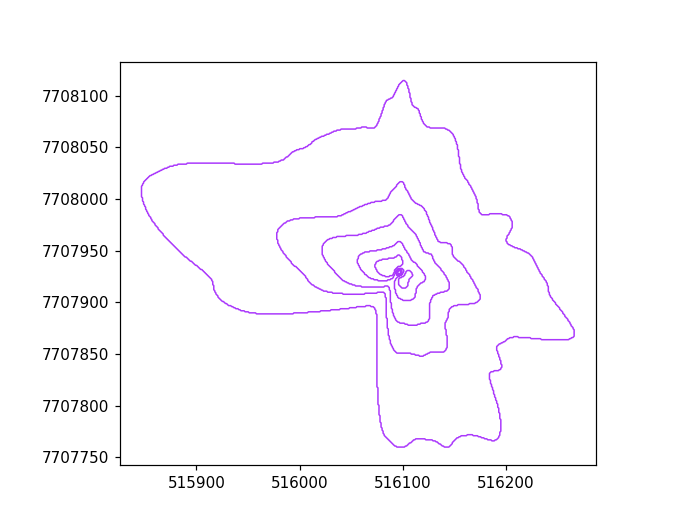

In [27]:
# plt.figure()
Go = True
if Go == True:
    importlib.reload(FP)
    FP_Data = FP.Calculate(RasterPath,Data,os.getcwd()+'/Basin_Image.tif',XY,Classes=Basin,
                          Name='Class',Code='Unit',nx=nx,dx=dx)
#     print(FP_Data.Intersections)
#     Data = Data.merge(FP_Data.Intersections,left_on='datetime',right_on='datetime', how='outer')
    
    FP_Data.Data['Out_of_Basin'] = FP_Data.Data['Upland']+FP_Data.Data['Ocean']+FP_Data.Data['Fen']+(1-Data['Sum'])
    FP_Data.Data.to_csv('Data_Footprints_'+str(datetime.datetime.now()).split(' ')[0]+'.csv')


## Query Footprints

<IPython.core.display.Javascript object>


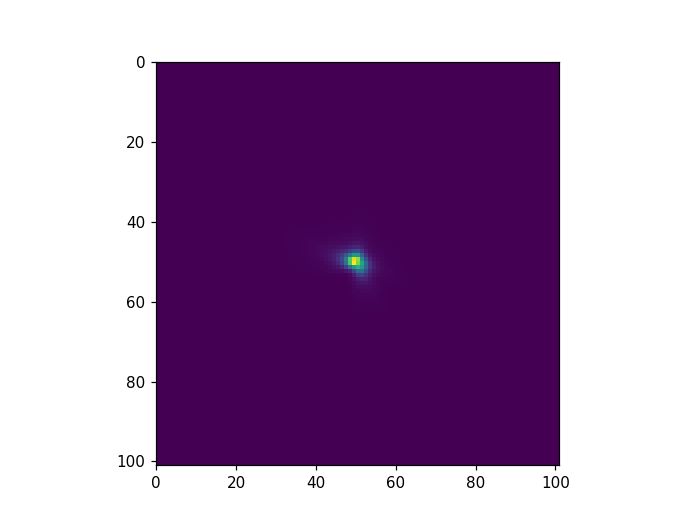

In [10]:
# print(np.sort(FP_Data.Sum))
# print(FP_Data.Sum)
# plt.figure()
# plt.imshow(FP_Data.Sum)
# plt.colorbar()
# import contours as c
plt.figure()
with rasterio.open('C:\\Illisarvik\\Footprints/Climatology.tiff','r',driver='GTiff',width = nx+1, height = nx+1,count = 1,
                   dtype=np.float64,affine = Transform,crs = ({'init': 'EPSG:32608'})) as out:
    show((out))